<a href="https://colab.research.google.com/github/turnippy/cisc856project/blob/main/CISC856Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CISC856 Group 6 Project Winter 2022

Contributors:
* P Saha
* T Liu

In [161]:
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
from itertools import product

In [145]:
class Environment:
  def __init__(self, n, c, t, gamma, ac, dca, dcb, demand=1):
    '''
    initialize with:
      n = number of affected areas
      c = capacities of response centers
      t = number of planning periods
      gamma
      ac = accessibility cost parameter
      dca = deprivation cost parameter 'a'
      dcb = deprivation cost parameter 'b'
      demand = 1 for all affected areas
      initial state = [0] * n (zero resources allocated intiially)
      initial time step = 1
    '''
    self.n = n
    self.c = c
    self.t = t #time horizon
    self.L = 72 / t #length of each planning period
    self.gamma = gamma
    self.ac = ac #vector with AC cost param of each affected area
    self.dca = dca
    self.dcb = dcb
    self.demand = np.array([demand] * n) #default=1 for all affected areas
    self.reset()

  def reset(self):
    self.state = np.zeros(self.n, dtype=int)
    self.curr_time = 1
    
  def take_action(self, action):
    '''
    action is a vector (a_1, a_2, ..., a_n),
    where each a_i represents the resource allocation to the 
    i-th affected area, given a total of 'n' affected areas

    demand is a vector (d_1, d_2, ..., d_n),
    where each d_i represents the demand for resources of the
    i-th affected area, given a total of 'n' affected areas

    Following figure (1):
    S_(i,t+1) = S_(i,t) - Y_(i,t) + D_(i,t)
    where Y_(i,t) denotes the resource allocation at time t for the i-th area,
    where D_(i,t) denotes the demand at time t for the i-th area.

    Advances state based on action and increments time step.
    
    Returns current state, reward, and time step.
    '''
    self.check_action(action)
    reward = self.calc_cost(action, self.state, self.get_next(self.state, action), self.curr_time)
    self.state = np.add(self.state, np.array(action) * -1)
    self.state = np.add(self.state, self.demand)
    self.curr_time += 1

    return copy.deepcopy(self.state), reward, self.curr_time

  def get_next(self, curr, action):
    next = copy.deepcopy(np.add(curr, np.array(action) * -1))
    next = np.add(next, self.demand)
    return next

  def check_action(self, action):
    '''
    checks if action and demand are legal under the given environment parameters
    '''
    if len(action) != self.n:
      raise ValueError('length of action tuple must equal number of affected areas')
    if sum(action) > self.c:
      raise ValueError('resource allocation must not exceed capacity')

  def calc_AC(self, action):
    #Omega function
    cost = 0
    for i in range(len(action)):
      cost += action[i] * self.ac[i]
    #print('\tAC: {}'.format(cost))
    return cost

  def calc_SDCC(self, state):
    #Tau function
    cost = 0
    for s in state:
      #approximation according to Yu et al. 2018:
      #cost += self.gamma * (self.L * (s + 1)) - self.gamma * (self.L * (s))
      #calculation according to equation 4 in Yu et al. 2018
      cost += (np.exp(self.L * self.dcb)-1) * np.exp(self.dca + (self.dcb*self.L*s))
    #print('\tstate: {}, sdcc: {}'.format(state,cost))
    return cost

  def calc_cost(self, action, state, next, time):
    '''
    calculates the reward for the chosen action in the given state and time step
    action must be a vector with size = n
    state must be a vector with size = n
    next must be a vector with size = n
    time must be an integer value, where 0 < time <= horizon+1
    '''
    next = self.get_next(state, action)
    reward = 0
    if time == 1:
      #following equation (7)
      reward -= self.calc_AC(action)
      reward -= self.calc_SDCC(state)
      reward -= self.calc_SDCC(next)
    elif time == (self.t + 1):
      #following equation (9)
      reward -= self.calc_AC(action)
      reward -= self.calc_SDCC(next)
    else:
      #following equation (8)
      reward -= self.calc_AC(action)
      reward -= self.calc_SDCC(next)
    return reward

In [157]:
class Agent:
  def __init__(self, env, k=2000, epsilon=0.5, alpha=0.8, gamma=0.8):
    '''
    initialize with:
      k = number of epochs
      epsilon
      alpha = learning rate
      gamma = discount factor
    '''
    self.env = env
    self.k = k
    self.epsilon = epsilon
    self._epsilon = epsilon #used to track startingg epsilon value
    self.alpha = alpha
    self.gamma = gamma
    self.initialize_q_table(self.env.n, self.env.c, self.env.t)
  
  def initialize_q_table(self, n, c, t):
    #q-table is maintained as a double hash table
    #the keys of the outer hash is the state tuple
    #the keys of the inner hash the action tuple in the given state
    self.q_table = {}
    #first, generate all possible states. by the problem descriptions, we assume
    #that S_(i,t) >= 0 for all i <= N, for all t <= T

    all_states = [i for i in product(range(-(t+1), t+2), repeat=n)]
    all_actions = []
    for item in product(range(0, c+1), repeat=n):
      if sum(item) <= c and sum(item) > 0:
        all_actions.append(item)

    for tup in all_states:
      self.q_table[tup] = {}
      for act in all_actions:
        self.q_table[tup][act] = 0

  def update_qtable(self, curr, action, reward, next):
    curr = tuple(curr)
    next = tuple(next)
    temp = []
    for a in self.q_table[next].keys():
      temp.append(self.q_table[next][a])
    self.q_table[curr][action] += self.alpha * (reward + self.gamma * max(temp) - self.q_table[curr][action])

  def action_selection(self, curr):
    curr = tuple(curr)
    if random.random() < self.epsilon:
      return random.choice(list(self.q_table[curr].keys()))

    best_q = -1
    best_actions = []
    for a in self.q_table[curr].keys():
      tmp = self.q_table[curr][a]
      if tmp > best_q:
        best_q = tmp
        best_actions = [a]
      if tmp == best_q:
        best_actions.append(a)
    return random.choice(best_actions)

  def train(self, k):
    training = []
    self.epsilon = self._epsilon
    for t in range(1, k+1):
      self.calc_epsilon(t, k)
      episode = self.train_episode(t)
      training.append(episode)
    return training

  def train_episode(self, epoch):
    curr = (0,) * self.env.n
    done = False
    #history = []
    total_cost = 0
    while not done:
        action = self.action_selection(curr)
        next, reward, t_step = self.env.take_action(action)
        self.update_qtable(curr, action, reward, next)
        #history.append((curr, action, reward))
        print('reward for this move: {}, next state: {}'.format(reward, next))
        total_cost += reward
        state = next
        if t_step >= self.env.t:
          self.env.reset()
          done = True
    if epoch % 50 == 0:
      print('Training Episode {} cost: {}.'.format(epoch, total_cost))
    return total_cost

  def calc_epsilon(self, current, total):
    #according to Yu et al 2021
    self.epsilon = 0.5 / (1 + np.exp(10*(current-0.4*total)/total))

  def get_params(self):
    ret = ''
    return ret

In [158]:
accessibility_costs = np.array([200,250,300,350,400,450,500,550,600,650])

e = Environment(n=3,c=1,t=6,gamma=0.5,ac=accessibility_costs,dca=2.04,dcb=0.24)
a = Agent(e, epsilon=0.5, alpha=0.8, gamma=0.2)

In [159]:
a.train_episode(1)

	state: [0 0 0], sdcc: 387.93601196276995
	state: [0 1 1], sdcc: 4736.5107328636495
reward for this move: -5324.4467448264195, next state: [0 1 1]
	state: [1 2 1], sdcc: 45644.14710335615
reward for this move: -45944.14710335615, next state: [1 2 1]
	state: [2 2 2], sdcc: 123110.84512344026
reward for this move: -123360.84512344026, next state: [2 2 2]


IndexError: ignored

In [160]:
a.q_table

{(-7, -7, -7): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -6): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -5): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -4): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -3): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -2): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, -1): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 0): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 1): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 2): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 3): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 4): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 5): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 6): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -7, 7): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -6, -7): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7, -6, -6): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0},
 (-7,

In [ ]:
result = a.train(k=2000)
len(result)

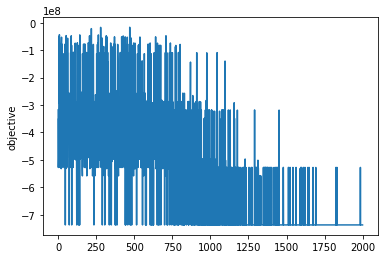

In [87]:
plt.plot(result)
plt.ylabel('objective')
plt.show()

In [33]:
test = np.array([1,2,3,4,5])
print(tuple(test))

test2=(1,2,3,4,5)
np.array(test2)

(1, 2, 3, 4, 5)


array([1, 2, 3, 4, 5])

In [76]:
print(np.exp(0.24*(72/5)*4 + 2.4))

11117155.347644882


In [77]:
0.24*(72/5)*4

13.824